In [21]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

pd.options.display.max_columns = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [22]:
housing = pd.read_csv('../data/Ames_Housing_Price_Data.csv', index_col = 0)
real_estate = pd.read_csv('../data/Ames_Real_Estate_Data.csv')
housing_df = pd.merge(housing,real_estate,left_on='PID',right_on='MapRefNo',how='inner')

house_df = pd.read_csv('../data/final_df.csv', index_col = 0)

D:\software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# Checking house price dataset, contains 2580 observations
housing.shape

(2580, 81)

In [145]:
house_df['Total_porch_sf']
plt.figure(figsize=(20,8))
plt.title('Porch Area and Price')
log_SF = np.log(ames_df['Total_porch_sf'])
log_SalePrice= np.log(ames_df['SalePrice'])
sns.scatterplot(x = log_SF, y = log_SalePrice, data = ames_df, x_estimator=np.mean)

0        166
1        105
3        282
4        279
5         45
6        177
7        144
8        124
9          0
10        44
11        35
12        22
13       128
14       261
15       266
16       240
17       362
18       100
19       236
20       280
21        32
22         0
23       187
24       567
25         0
26       133
27       118
28        32
29       667
30       428
31       244
32         0
33        59
34       220
35         0
36       148
37       225
38        78
40       224
41         0
43       315
44       278
46       448
47       277
49       112
50       394
51       148
52       160
53       186
54       202
55       982
56       120
57       527
58       252
59       120
60        92
61       360
62         0
63       620
64       562
65       112
66       366
67       254
68       394
69       365
70       435
71       491
72       230
73       430
74       131
75       100
76       210
77       187
78       368
79       100
80        36
81       328

In [24]:
# Checking final_df after generating geoCode, found duplicated observations
house_df.shape

(2603, 179)

In [25]:
# Test cell, ignored! 
house_df_test = house_df.copy()
len(house_df_test.drop_duplicates(subset=['PID'],keep = 'first'))

2558

In [26]:
# drop duplicated observations
house_df = house_df.drop_duplicates(subset=['PID'],keep = 'first')
house_df.shape

(2558, 179)

In [27]:
len(house_df[house_df['YrSold']==2010])

314

## Yi's Feature engineer

In [28]:
# calculate age of building
house_df['BldgAge'] = house_df['YrSold'] - house_df['YearBuilt']

# convert MSSubClass to str
house_df['MSSubClass'] = house_df[['MSSubClass']].astype('str')
house_df['TxD_S'] = house_df[['TxD_S']].astype('str')
house_df['SchD_S'] = house_df[['SchD_S']].astype('str')

# convert NA's to 0s in LotFrontage
house_df['LotFrontage'] = np.where(np.isnan(house_df['LotFrontage']), 0, house_df['LotFrontage'])

# binarize YearRemodAdd
house_df['Remodeled'] = np.where(house_df['YearRemodAdd'] == house_df['YearBuilt'], 0, 1)

# binarize Alley
house_df['Alley'] = np.where(pd.isnull(house_df['Alley']), 0, 1)

# binarize MSSubClass to PUD or not PUD
house_df['IsPUD'] = np.where(house_df['MSSubClass'].isin(['120','150','160','180']), 1, 0)

# binarize LotShape to Reg or not Reg
house_df['LotIsReg'] = np.where(house_df['LotShape']=='Reg', 1, 0)

# binarize Condition1/2 to positive feature or no positive feature
house_df['PosFeat'] = np.where(house_df['Condition1'].isin(['PosN','PosA'])|\
                                house_df['Condition2'].isin(['PosN','PosA']), 1, 0)

# binarize condition 1/2 to normal sorroundings or not normal surroundings
house_df['SurrIsNormal'] = np.where((house_df['Condition1']=='Norm') & (house_df['Condition2']=='Norm'), 1, 0)

# binarize condition 1/2 to normal sale condition or not sale condition
house_df['Salecondition'] = np.where((house_df['SaleCondition']=='Normal'), 1, 0)

house_df['ExtMatl'] = np.where((house_df['Exterior1st']==house_df['Exterior2nd']),house_df['Exterior1st'], 'Mixed')


## Daniel's Feature engineer

In [29]:
house_df['BsmtExposure2']=np.where((house_df['BsmtExposure']=='Av')|(house_df['BsmtExposure']=='Gd'),1,0)



## Danny's Feature engineer

In [30]:
house_df['Total_porch_sf'] = house_df['OpenPorchSF'] + house_df['3SsnPorch'] + house_df['EnclosedPorch'] +\
                            house_df['ScreenPorch'] + house_df['WoodDeckSF']

### These are the features I selected from the first 27 features: 
- GrLivArea
- LotArea
- BldgAge
- Remodeled
- IsPUD
- LotIsReg
- PosFeat
- SurrIsNormal (unsure about this one)

In [31]:
house_df.corr()

,index,PID,GrLivArea,SalePrice,Distance,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MasVnrArea2,GarageArea2,PoolArea2,HalfBath2,BsmtHalfBath2,BasmtFinSF1,BasmtFinSF2,BasmtFinSF,total_LivArea,num_bathroom,GeoRefNo,Tier,Range,MA_Line2,MA_Zip1,MA_Zip2,Rcrd_Yr,Rcrd_Mo,Inst1_Yr,Inst1_Mo,LndAc_S,ImpAc_S,OthAc_S,TtlVal_AsrYr,X2TPr_D,X2TSc_D,X2TPr_S,X2TSc_S,LndAcX1S,ImpAcX1S,ImpAcX2S,HSTtl_D,MilVal_D,HSTtl_S,MilVal_S,AcreX_S1,AcreGr,AcreNt_S,BldgNo_S,DwlgNo_S,YrBuilt,GLA,TtlBsmtSF,GarYrBlt,Cars,YrSold_YYYY,MoSold_MM,PA-Nmbr,PA-PostD,NmbrBRs,address3,latitude2,longitude2,altitude2,ISU_lat,ISU_long,BldgAge,Remodeled,IsPUD,LotIsReg,PosFeat,SurrIsNormal,Salecondition,BsmtExposure2,Total_porch_sf
index,1.000000e+00,2.791739e-02,-1.261419e-02,-5.739388e-02,-2.427344e-02,-2.894691e-02,-3.329784e-02,7.034381e-04,-4.428859e-02,3.092424e-02,-5.361013e-02,-4.334595e-02,-3.161820e-02,-4.813020e-02,2.550290e-02,-5.648592e-03,-4.471576e-02,-3.418459e-02,1.391125e-02,1.790329e-02,-1.857289e-02,1.160716e-02,-5.058203e-03,-1.928123e-02,3.279934e-02,1.963806e-02,1.298555e-02,-1.102082e-02,-4.594916e-02,-4.044620e-02,-4.090368e-02,3.144988e-03,-2.671177e-02,-1.581100e-02,-2.880524e-02,1.735681e-02,7.539172e-03,-5.091314e-03,-2.684664e-02,3.689590e-02,-1.606140e-02,-3.984139e-02,7.539172e-03,-1.659909e-02,1.862167e-02,-5.715182e-02,1.034314e-02,-5.359411e-02,-4.152677e-02,-1.946676e-02,2.791739e-02,NaN,NaN,NaN,-2.712432e-02,2.387474e-02,2.733173e-02,-1.727746e-02,2.733173e-02,-1.727746e-02,-6.837646e-02,NaN,-6.538777e-02,-6.619668e-02,NaN,NaN,NaN,NaN,-1.626887e-02,1.419935e-02,NaN,-4.009877e-03,NaN,-3.215938e-03,NaN,-2.663358e-02,-2.993367e-03,-2.496089e-02,NaN,2.637898e-02,4.377950e-03,-1.233659e-02,-4.134013e-02,-1.520349e-02,-4.402276e-02,1.343176e-02,-2.036210e-02,1.443090e-02,NaN,3.544494e-02,1.443090e-02,-2.112852e-02,1.709440e-02,NaN,4.625062e-14,1.895199e-14,5.523547e-02,1.922232e-03,-1.925056e-02,1.681331e-02,1.572690e-03,-2.253894e-02,2.841051e-01,-5.301140e-02,-1.294672e-02
PID,2.791739e-02,1.000000e+00,-1.035972e-01,-2.280929e-01,-1.759347e-01,-3.066857e-02,4.140111e-02,9.096190e-02,-2.475504e-01,1.218971e-01,-3.379339e-01,-1.285462e-01,-2.287169e-01,-1.120034e-01,-1.270685e-03,-7.265161e-02,-1.901503e-01,-1.543005e-01,1.133257e-02,5.905988e-02,-4.080844e-02,2.159106e-04,-1.559727e-01,-1.749148e-01,2.151015e-03,4.928582e-02,-7.507457e-02,-1.065517e-01,-2.580216e-01,-2.207168e-01,-1.984560e-01,-3.987737e-02,-5.932387e-02,1.715473e-01,-2.064363e-02,-3.075141e-02,-6.196802e-03,-2.198603e-02,-6.365961e-02,4.873327e-03,-2.338928e-01,-1.991345e-01,-6.196802e-03,-1.730355e-01,-2.187923e-04,-9.993216e-02,2.911749e-02,-9.067746e-02,-1.250181e-01,-1.891450e-01,1.000000e+00,NaN,NaN,NaN,1.272370e-02,5.082690e-01,6.735089e-03,-1.124304e-02,6.735089e-03,-1.124304e-02,-2.188482e-01,NaN,-2.174008e-01,-2.179672e-01,NaN,NaN,NaN,NaN,4.016809e-02,1.839779e-02,NaN,-3.889049e-02,NaN,-2.245859e-02,NaN,3.573399e-02,-3.972935e-03,3.621383e-02,NaN,-4.047514e-02,-1.833764e-01,-9.640373e-02,-1.862921e-01,-1.537132e-01,-2.149999e-01,5.513727e-02,-5.369770e-03,-1.692794e-01,NaN,-1.571142e-03,-1.692794e-01,-8.054421e-01,-2.050632e-01,NaN,6.760472e-16,1.131389e-15,3.380931e-01,2.227591e-01,-1.462217e-01,1.300698e-01,-7.540392e-02,4.872405e-02,6.993464e-02,3.878275e-02,-1.829076e-03
GrLivArea,-1.261419e-02,-1.035972e-01,1.000000e+00,7.198022e-01,1.797821e-02,1.467564e-01,2.611281e-01,-2.800647e-03,5.600393e-01,-1.109892e-01,2.287499e-01,3.037251e-01,3.886588e-01,1.642282e-01,-2.042461e-02,2.438666e-01,4.095695e-01,5.389424e-01,6.644188e-01,8.921815e-02,4.247845e-02,-5.339892e-02,6.435057e-01,4.446041e-01,5.371289e-01,1.301704e-01,8.066151e-01,4.570

In [32]:
pd.options.display.max_rows = None
house_df.corr()['SalePrice'].sort_values()

BldgAge          -5.442518e-01
LotIsReg         -3.016197e-01
longitude2       -2.547675e-01
MA_Zip2          -2.321861e-01
PID              -2.280929e-01
GeoRefNo         -2.280929e-01
Salecondition    -1.306464e-01
EnclosedPorch    -1.202169e-01
KitchenAbvGr     -1.152058e-01
Rcrd_Yr          -1.144998e-01
Inst1_Yr         -1.144998e-01
Alley            -1.135083e-01
OverallCond      -1.066500e-01
YrSold_YYYY      -6.320549e-02
index            -5.739388e-02
Remodeled        -5.251723e-02
BsmtHalfBath2    -3.622162e-02
Inst1_Mo         -3.603198e-02
Rcrd_Mo          -3.603198e-02
BsmtHalfBath     -3.400554e-02
IsPUD            -3.187890e-02
LowQualFinSF     -3.126661e-02
MiscVal          -1.923813e-02
ImpAcX1S         -9.399524e-03
MA_Zip1          -7.395858e-03
ISU_long          4.820486e-16
ISU_lat           6.908338e-16
YrSold            9.976053e-04
MoSold            1.382741e-02
AcreGr            1.480496e-02
HSTtl_S           1.771794e-02
MoSold_MM         1.832749e-02
BsmtFinS

In [33]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 1 to 763
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2580 non-null   int64  
 1   GrLivArea      2580 non-null   int64  
 2   SalePrice      2580 non-null   int64  
 3   MSSubClass     2580 non-null   int64  
 4   MSZoning       2580 non-null   object 
 5   LotFrontage    2118 non-null   float64
 6   LotArea        2580 non-null   int64  
 7   Street         2580 non-null   object 
 8   Alley          168 non-null    object 
 9   LotShape       2580 non-null   object 
 10  LandContour    2580 non-null   object 
 11  Utilities      2580 non-null   object 
 12  LotConfig      2580 non-null   object 
 13  LandSlope      2580 non-null   object 
 14  Neighborhood   2580 non-null   object 
 15  Condition1     2580 non-null   object 
 16  Condition2     2580 non-null   object 
 17  BldgType       2580 non-null   object 
 18  HouseStyl

In [34]:
real_estate.isnull().sum()

MapRefNo            0
GeoRefNo            0
Tier                0
Range               0
Prop_Addr          20
ZngCdPr           106
ZngCdSc         22187
ZngOLPr         20243
ZngOLSc         22060
ClassPr_S           0
ClassSc_S           0
Legal_Pr            0
SchD_S              0
TxD_S               0
MA_Ownr1            0
MA_Ownr2        19337
MA_Line1           14
MA_Line2        22213
MA_City            14
MA_State           14
MA_Zip1            14
MA_Zip2          8890
Rcrd_Yr          1907
Rcrd_Mo          1907
Inst1_No         1857
Inst1_Yr         1907
Inst1_Mo         1907
Inst1TPr         2677
LndAc_S             0
ImpAc_S             0
OthAc_S             0
TtlVal_AsrYr        0
ValType             0
X1TPr_D         21519
X1TSc_D         21519
X2TPr_D         22212
X2TSc_D         22212
X1TPr_S         21522
X1TSc_S         21522
X2TPr_S         22212
X2TSc_S         22212
LndAcX1S            0
ImpAcX1S            0
ImpAcX2S            0
HSTtl_D         13024
MilVal_D  

In [35]:
pd.set_option('display.max_rows',None)


## Features that drop because of too many missing values
- PoolArea
- PoolQC
- MiscFeature
- MiscVal
- YrSold_YYYY
- MoSold_MM
- SaleCond
- PA-PreD
- PA-PostD
- PA-UnTyp
- PA-UntNo
- X1TPr_D
- X1TSc_D
- X2TPr_D
- X2TSc_D
- X1TPr_S
- X1TSc_S
- X2TPr_S
- X2TSc_S

## Features that drop because of multicollinearity
- ISU_lat_long
- address_lat_long
- FullBath 
- HalfBath
- MA_Ownr1
- MA_Ownr2
- MA_Line1
- MA_Line2
- MA_City
- MA_State
- location
- point


## Features that drop because of p value
- MasVnrArea2
- BsmtQual
- BsmtCond
- BsmtExposure
- Electrical

In [36]:
house_df_test = house_df.drop(['Alley','PoolArea','PoolQC','MiscFeature','MiscVal','YrSold_YYYY','MoSold_MM','SaleCond','PA-PreD','PA-PostD',\
                        'PA-UnTyp','PA-UntNo','X1TPr_D','X1TSc_D','X2TPr_D','X2TSc_D','X1TPr_S','X1TSc_S','X2TPr_S','X2TSc_S',\
                       'ISU_lat_long','address','FullBath','HalfBath','MA_Ownr1','MA_Ownr2','MA_Line1','MA_Line2',\
                        'MA_City','MA_State','address3','location2','point2','Street','index','PID','Utilities','BsmtHalfBath2',\
                        'HalfBath2','BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2',\
                        'Source','Date','ParType','BldgNo_S','DwlgNo_S','YrBuilt','Ext1','Ext2','Central Air','GLA','TtlBsmtSF',\
                        'GarYrBlt','Cars','MA_Zip1','MA_Zip2','ZngCdPr','ZngCdSc','ZngOLPr','ZngOLSc','PA-Nmbr','PA-Strt',\
                        'PA-StSfx','Inst1_No','Inst1_Yr','Inst1_Mo','Inst1TPr','TtlVal_AsrYr','ValType','OthAc_S','ImpAc_S',\
                        'LndAc_S','Prop_Addr','HSTtl_D','MilVal_D','HSTtl_S','MilVal_S','GeoRefNo','Tier','Range','AcreX_S1',\
                        'ClassPr_S','ClassSc_S','LndAcX1S','ImpAcX1S','ImpAcX2S','AcreGr','AcreNt_S','ParclRel','WoodDeckSF',\
                        'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','SaleCondition','Rcrd_Yr','Rcrd_Mo','Legal_Pr',\
                        'GrLivArea','Condition1','Condition2','1stFlrSF','2ndFlrSF','YearRemodAdd','YearBuilt','MasVnrType',\
                        'MasVnrArea','GarageArea2','PoolArea2','BsmtQual','BsmtCond','BsmtUnfSF','LowQualFinSF','BasmtFinSF2',\
                        'BasmtFinSF1','NmbrBRs','altitude2','LotShape','Neighborhood','HouseStyle','BedroomAbvGr','num_bathroom',\
                        'MSSubClass','BsmtExposure','TotalBsmtSF','GarageYrBlt','Exterior1st','Exterior2nd','address2',\
                        'MSZoning','latitude2','longitude2','SchD_S','KitchenQual','LotArea','ExterCond','ISU_lat','ISU_long',\
                        'Functional'],axis=1)
house_df_test.info()
house_df_test.corr()['SalePrice'].sort_values()
# house_df_test.isnull().sum()

# Impute None to Nan value in columns
impute_feature1 = house_df_test[['FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','Fence']]
for feature in impute_feature1.columns:
    house_df_test[feature] = house_df_test[feature].fillna('None')
    
house_df_test = house_df_test.drop(2465,axis=0)
house_df_test = house_df_test.drop(437,axis=0)

house_df_test.isnull().sum()

# Train-test split 
train = house_df_test[house_df_test['YrSold']!=2010]
test = house_df_test[house_df_test['YrSold']==2010]
print(train.shape)
print(test.shape)
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
X_test = test.drop(['SalePrice'],axis=1)
y_test = test['SalePrice']

X_train_dum = pd.get_dummies(X_train, drop_first=True)
print(X_train.shape)
print(len(X_train_dum.columns))

# apply log to area and house price
X_train_dum['LotFrontage'] = np.log(X_train_dum['LotFrontage']+1)
# X_train_dum['LotArea'] = np.log(X_train_dum['LotArea']+1)
X_train_dum['total_LivArea'] = np.log(X_train_dum['total_LivArea']+1)
X_train_dum['Total_porch_sf'] = np.log(X_train_dum['Total_porch_sf']+1)
y_train = np.log(y_train)

lin_reg = LinearRegression().fit(X_train_dum, y_train)
lin_reg.score(X_train_dum,y_train)



x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

X_vif = X_train_dum[pValue[pValue<0.05].drop('const').index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 0 to 2602
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SalePrice       2558 non-null   int64  
 1   Distance        2558 non-null   float64
 2   LotFrontage     2558 non-null   float64
 3   LandContour     2558 non-null   object 
 4   LotConfig       2558 non-null   object 
 5   LandSlope       2558 non-null   object 
 6   BldgType        2558 non-null   object 
 7   OverallQual     2558 non-null   int64  
 8   OverallCond     2558 non-null   int64  
 9   RoofStyle       2558 non-null   object 
 10  RoofMatl        2558 non-null   object 
 11  ExterQual       2558 non-null   object 
 12  Foundation      2558 non-null   object 
 13  Heating         2558 non-null   object 
 14  HeatingQC       2558 non-null   object 
 15  CentralAir      2558 non-null   object 
 16  Electrical      2557 non-null   object 
 17  KitchenAbvGr    2558 non-null   i

BldgAge          -0.544252
LotIsReg         -0.301620
Salecondition    -0.130646
KitchenAbvGr     -0.115206
OverallCond      -0.106650
Remodeled        -0.052517
IsPUD            -0.031879
YrSold            0.000998
MoSold            0.013827
SurrIsNormal      0.096833
PosFeat           0.125170
LotFrontage       0.183032
Distance          0.191794
BsmtExposure2     0.354009
MasVnrArea2       0.386136
Total_porch_sf    0.393583
Fireplaces        0.487162
TotRmsAbvGrd      0.488835
BasmtFinSF        0.551436
GarageArea        0.636363
GarageCars        0.639794
OverallQual       0.790448
total_LivArea     0.820051
SalePrice         1.000000
Name: SalePrice, dtype: float64

SalePrice         0
Distance          0
LotFrontage       0
LandContour       0
LotConfig         0
LandSlope         0
BldgType          0
OverallQual       0
OverallCond       0
RoofStyle         0
RoofMatl          0
ExterQual         0
Foundation        0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
FireplaceQu       0
GarageType        0
GarageFinish      0
GarageCars        0
GarageArea        0
GarageQual        0
GarageCond        0
PavedDrive        0
Fence             0
MoSold            0
YrSold            0
SaleType          0
MasVnrArea2       0
BasmtFinSF        0
total_LivArea     0
TxD_S             0
BldgAge           0
Remodeled         0
IsPUD             0
LotIsReg          0
PosFeat           0
SurrIsNormal      0
Salecondition     0
ExtMatl           0
BsmtExposure2     0
Total_porch_sf    0
dtype: int64

(2242, 46)
(314, 46)
(2242, 45)
120


0.9161260932945068

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     196.5
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:30:27   Log-Likelihood:                 1752.9
No. Observations:                2242   AIC:                            -3268.
Df Residuals:                    2123   BIC:                            -2588.
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.3131      4

const                 1.275946e-02
Distance              4.357765e-14
OverallQual           2.340662e-74
OverallCond           4.585934e-46
TotRmsAbvGrd          2.233688e-03
Fireplaces            6.122395e-11
GarageCars            2.460866e-02
GarageArea            4.415046e-12
BasmtFinSF            2.119078e-17
total_LivArea        3.894060e-114
BldgAge               8.579744e-30
LotIsReg              1.357457e-03
PosFeat               3.297916e-06
SurrIsNormal          1.923378e-12
Salecondition         8.257482e-05
BsmtExposure2         2.888238e-05
Total_porch_sf        2.955866e-03
LandContour_HLS       2.014880e-04
LandContour_Low       1.850400e-02
LandContour_Lvl       3.600553e-02
LandSlope_Mod         4.192894e-03
BldgType_2fmCon       1.910124e-02
BldgType_Duplex       1.031143e-02
BldgType_Twnhs        1.508770e-03
RoofMatl_WdShngl      2.661128e-03
ExterQual_Fa          1.440611e-05
ExterQual_Gd          5.959194e-06
ExterQual_TA          4.586669e-08
Foundation_PConc    

              feature         VIF
0            Distance   15.802128
1         OverallQual   70.121318
2         OverallCond   38.493218
3        TotRmsAbvGrd   35.999800
4          Fireplaces    3.644043
5          GarageCars   38.422598
6          GarageArea   31.842063
7          BasmtFinSF    3.247209
8       total_LivArea  382.117298
9             BldgAge   10.210720
10           LotIsReg    3.272841
11            PosFeat    1.278751
12       SurrIsNormal    9.323779
13      Salecondition   30.001913
14      BsmtExposure2    1.827375
15     Total_porch_sf    7.009812
16    LandContour_HLS    2.148299
17    LandContour_Low    1.723431
18    LandContour_Lvl   28.588179
19      LandSlope_Mod    1.416693
20    BldgType_2fmCon    1.179507
21    BldgType_Duplex    1.365677
22     BldgType_Twnhs    1.171496
23   RoofMatl_WdShngl    1.062219
24       ExterQual_Fa    1.865221
25       ExterQual_Gd   15.950293
26       ExterQual_TA   37.158975
27   Foundation_PConc    4.406582
28    Foundati

In [115]:
house_df.isnull().sum()

index                0
PID                  0
GrLivArea            0
SalePrice            0
Distance             0
MSSubClass           0
MSZoning             0
LotFrontage          0
LotArea              0
Street               0
Alley                0
LotShape             0
LandContour          0
Utilities            0
LotConfig            0
LandSlope            0
Neighborhood         0
Condition1           0
Condition2           0
BldgType             0
HouseStyle           0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
RoofStyle            0
RoofMatl             0
Exterior1st          0
Exterior2nd          0
MasVnrType          14
MasVnrArea          14
ExterQual            0
ExterCond            0
Foundation           0
BsmtQual            64
BsmtCond            64
BsmtExposure        66
BsmtFinType1        64
BsmtFinSF1           1
BsmtFinType2        65
BsmtFinSF2           1
BsmtUnfSF            1
TotalBsmtSF          1
Heating    

In [37]:
house_df_test.isnull().sum()

SalePrice         0
Distance          0
LotFrontage       0
LandContour       0
LotConfig         0
LandSlope         0
BldgType          0
OverallQual       0
OverallCond       0
RoofStyle         0
RoofMatl          0
ExterQual         0
Foundation        0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
FireplaceQu       0
GarageType        0
GarageFinish      0
GarageCars        0
GarageArea        0
GarageQual        0
GarageCond        0
PavedDrive        0
Fence             0
MoSold            0
YrSold            0
SaleType          0
MasVnrArea2       0
BasmtFinSF        0
total_LivArea     0
TxD_S             0
BldgAge           0
Remodeled         0
IsPUD             0
LotIsReg          0
PosFeat           0
SurrIsNormal      0
Salecondition     0
ExtMatl           0
BsmtExposure2     0
Total_porch_sf    0
dtype: int64

In [38]:
house_df_test.groupby(['Functional']).count()

KeyError: 'Functional'

In [39]:
# Impute None to Nan value in columns
impute_feature1 = house_df_test[['FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','Fence']]
for feature in impute_feature1.columns:
    house_df_test[feature] = house_df_test[feature].fillna('None')

In [ ]:
house_df_test.isnull().sum()

In [ ]:
house_df_test = house_df_test.drop(2465,axis=0)
house_df_test = house_df_test.drop(437,axis=0)

In [ ]:
house_df_test[house_df_test['Electrical'].isnull()]

In [ ]:
house_df_test[house_df_test['GarageCars'].isnull()]

In [ ]:
house_df_test[house_df_test['TotalBath'].isnull()]

In [ ]:
house_df_test.loc[house_df_test.index == 2328,'TotalBath'] = 3.5

In [ ]:
house_df_test.shape

In [ ]:
house_df_test[house_df_test.index == 918 ]['TotalBath']

In [ ]:
house_df_test.shape

In [ ]:
house_df_test.isnull().sum()

In [ ]:
house_df_test.info()

### Train-test split

In [40]:
# Train-test split 
train = house_df_test[house_df_test['YrSold']!=2010]
test = house_df_test[house_df_test['YrSold']==2010]
print(train.shape)
print(test.shape)
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
X_test = test.drop(['SalePrice'],axis=1)
y_test = test['SalePrice']

(2242, 46)
(314, 46)


In [ ]:
# Train-test split 
train = house_df_test[house_df_test['YrSold']!=2010]
test = house_df_test[house_df_test['YrSold']==2010]
print(train.shape)
print(test.shape)
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
X_test = test.drop(['SalePrice'],axis=1)
y_test = test['SalePrice']

In [41]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
print(X_train.shape)
print(len(X_train_dum.columns))

(2242, 45)
120


In [42]:
X_train_dum.columns[-50:]

Index(['FireplaceQu_None', 'FireplaceQu_Po', 'FireplaceQu_TA',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None',
       'GarageFinish_None', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_None',
       'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_P', 'PavedDrive_Y',
       'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None', 'SaleType_CWD',
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleType_VWD', 'SaleType_WD ',
       'TxD_S_45', 'ExtMatl_AsphShn', 'ExtMatl_BrkFace', 'ExtMatl_CBlock',
       'ExtMatl_HdBoard', 'ExtMatl_ImStucc', 'ExtMatl_MetalSd',
       'ExtMatl_Mixed', 'ExtMatl_Plywood', 'ExtMatl_PreCast', 'ExtMatl_Stucco',
       'ExtMatl_VinylSd', 'ExtMatl_Wd Sdng'],
      dt

In [43]:
# apply log to area and house price
X_train_dum['LotFrontage'] = np.log(X_train_dum['LotFrontage']+1)
# X_train_dum['LotArea'] = np.log(X_train_dum['LotArea']+1)
X_train_dum['total_LivArea'] = np.log(X_train_dum['total_LivArea']+1)
X_train_dum['Total_porch_sf'] = np.log(X_train_dum['Total_porch_sf']+1)
y_train = np.log(y_train)

lin_reg = LinearRegression().fit(X_train_dum, y_train)
lin_reg.score(X_train_dum,y_train)

0.9161260932945068

In [116]:
house_df_test_dum = pd.get_dummies(house_df_test, drop_first=True)

house_df_test_dum['LotFrontage'] = np.log(house_df_test_dum['LotFrontage']+1)
# house_df_test_dum['LotArea'] = np.log(house_df_test_dum['LotArea']+1)
house_df_test_dum['total_LivArea'] = np.log(house_df_test_dum['total_LivArea']+1)
house_df_test_dum['Total_porch_sf'] = np.log(house_df_test_dum['Total_porch_sf']+1)
house_df_test_dum['SalePrice'] = np.log(house_df_test_dum['SalePrice'])

train1 = house_df_test_dum[house_df_test['YrSold']!=2010]
test1 = house_df_test_dum[house_df_test['YrSold']==2010]
# print(train1.shape)
# print(test1.shape)
X_train1 = train1.drop(['SalePrice'],axis=1)
y_train1 = train1['SalePrice']
X_test1 = test1.drop(['SalePrice'],axis=1)
y_test1 = test1['SalePrice']


# linear regresion model
lin_reg1 = LinearRegression().fit(X_train1, y_train1)
print(f'R^2 of Train set: {lin_reg1.score(X_train1,y_train1)}')
print(f'R^2 of Test set: {lin_reg1.score(X_test1,y_test1)}')


R^2 of Train set: 0.9161260932945068
R^2 of Test set: 0.8488513798139916


In [117]:
from sklearn.metrics import mean_squared_error
house_prediction = lin_reg1.predict(X_train1)
house_prediction
lin_mse = mean_squared_error(y_train, house_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


array([11.82151344, 11.85995761, 11.50555019, ..., 11.98101498,
       12.30864988, 12.39082464])

0.11071528915665545

In [139]:
# Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=10).fit(X_train1,y_train1)
print(f'R^2 of Train set: {tree_reg.score(X_train1,y_train1)}')
print(f'R^2 Test set: {tree_reg.score(X_test1,y_test1)}')

# from graphviz import Source
# from sklearn import tree
# from IPython.display import SVG
# treeIdx = 40 # has to be less than 50

# graph = Source(tree.export_graphviz(randomForest.estimators_[treeIdx], out_file=None, feature_names=spam_train.columns[:57]))
# SVG(graph.pipe(format='svg'))


from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_reg.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_reg, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
%time grid_search_tree.fit(X_train1, y_train1)

R^2 of Train set: 0.9710625173840916
R^2 Test set: 0.7639303978791621


DecisionTreeRegressor(max_depth=10, random_state=108)

KeyError: 'gini'

<AxesSubplot:xlabel='name'>

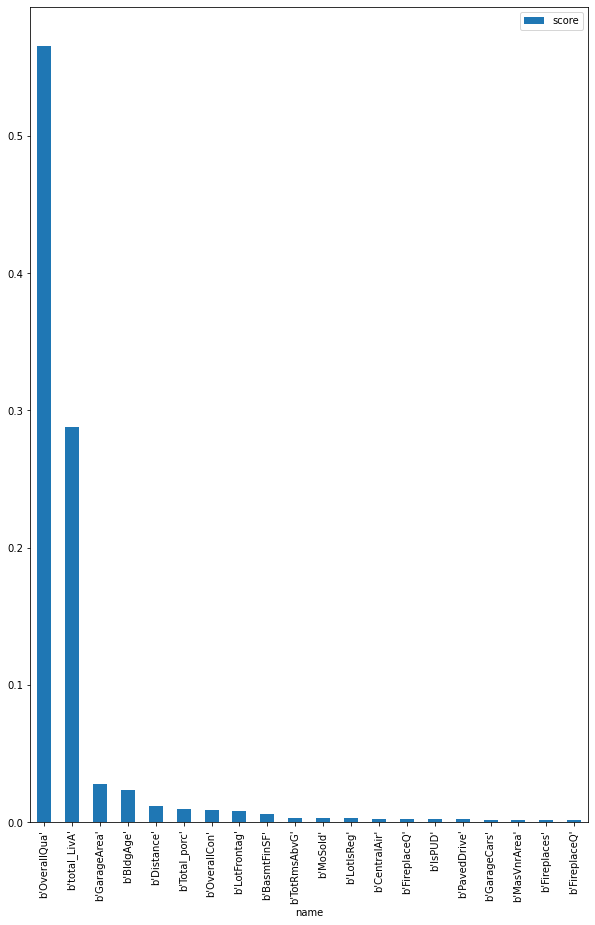

In [144]:
feature_importance = list(zip(X_train1.columns ,tree_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')


In [119]:
# Random Forest Model n_estimators = 1000
forest_reg = RandomForestRegressor(n_estimators=1000,max_features=5).fit(X_train1,y_train1)
print(f'R^2 of Train set: {forest_reg.score(X_train1,y_train1)}')
print(f'R^2 Test set: {forest_reg.score(X_test1,y_test1)}')

R^2 of Train set: 0.9814767553175812
R^2 Test set: 0.7944412241633623


In [49]:
# Random Forest Model n_estimators = 10
forest_reg = RandomForestRegressor(n_estimators=10,max_features=5).fit(X_train1,y_train1)
print(f'R^2 of Train set: {forest_reg.score(X_train1,y_train1)}')
print(f'R^2 Test set: {forest_reg.score(X_test1,y_test1)}')

R^2 of Train set: 0.9669987754724593
R^2 Test set: 0.7673090393622566


In [130]:
# graph = Source(tree.export_graphviz(forest_reg.estimators_[treeIdx], out_file=None, feature_names=X_train1.columns))
# SVG(graph.pipe(format='svg'))

In [134]:
grid_para_forest = [{
    "n_estimators": [25, 50, 100],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(forest_reg, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train1, y_train1)




KeyError: 'gini'

In [ ]:
grid_search_forest.best_params_

<AxesSubplot:xlabel='name'>

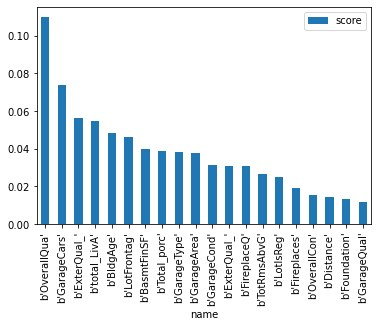

In [55]:
feature_importance = list(zip(X_train1.columns, forest_reg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of 1000-Tree GBM')

In [121]:
# Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor().fit(X_train1, y_train1)
print(f'R^2 of Train set: {gbm.score(X_train1,y_train1)}')
print(f'R^2 Test set: {gbm.score(X_test1,y_test1)}')

R^2 of Train set: 0.9447268732586506
R^2 Test set: 0.8584787386486971


In [92]:
gbm.set_params(learning_rate=0.1, n_estimators=1000, verbose=1,sub warm_start=False, loss='ls', max_depth=2,\
               max_features=2, min_impurity_decrease=0.01)
gbm.fit(X_train1,y_train1)
print("The train set R^2 is %.3f" %(gbm.score(X_train1, y_train1)))
print("The test set R^2 is %.3f" %(gbm.score(X_test1,y_test1)))

GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=1000,
                          verbose=1)

      Iter       Train Loss   Remaining Time 
         1           0.0010            0.00s
         2           0.0009            0.50s
         3           0.0009            0.33s
         4           0.0009            0.50s
         5           0.0008            0.60s
         6           0.0008            0.50s
         7           0.0008            0.57s
         8           0.0008            0.50s
         9           0.0008            0.55s
        10           0.0008            0.59s
        20           0.0006            0.49s
        30           0.0004            0.48s
        40           0.0003            0.46s
        50           0.0003            0.46s
        60           0.0003            0.45s
        70           0.0003            0.44s
        80           0.0002            0.41s
        90           0.0002            0.40s
       100           0.0002            0.40s
       200           0.0002            0.31s
       300           0.0002            0.26s
       40

GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=1000,
                          verbose=1)

The train set R^2 is 0.862
The test set R^2 is 0.780


In [95]:
X_train1.columns

Index(['Distance', 'LotFrontage', 'OverallQual', 'OverallCond', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'MoSold',
       ...
       'ExtMatl_CBlock', 'ExtMatl_HdBoard', 'ExtMatl_ImStucc',
       'ExtMatl_MetalSd', 'ExtMatl_Mixed', 'ExtMatl_Plywood',
       'ExtMatl_PreCast', 'ExtMatl_Stucco', 'ExtMatl_VinylSd',
       'ExtMatl_Wd Sdng'],
      dtype='object', length=120)

                    0         1
0         OverallQual  0.178199
1          GarageArea  0.138281
2       total_LivArea  0.070793
3          Fireplaces  0.068719
4          GarageCars  0.043657
5      Total_porch_sf  0.039582
6            TxD_S_45  0.038106
7         MasVnrArea2  0.034295
8       BsmtExposure2  0.028259
9        TotRmsAbvGrd  0.026311
10        LotFrontage  0.024625
11       PavedDrive_Y  0.022739
12  Foundation_CBlock  0.021008
13         BasmtFinSF  0.018630
14       ExterQual_TA  0.018267
15   Foundation_PConc  0.018067
16        OverallCond  0.017764
17           LotIsReg  0.017411
18       HeatingQC_TA  0.014827
19     FireplaceQu_Gd  0.014495


<AxesSubplot:xlabel='feature_name'>

Text(0.5, 1.0, 'Feature Importance Plot of 1000-Tree GBM')

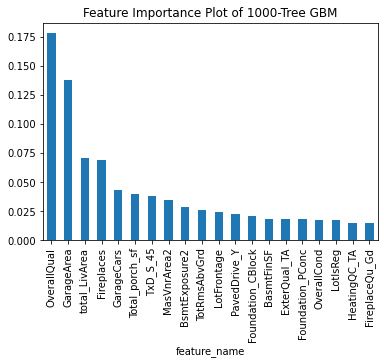

In [103]:
sorted_importance = sorted(zip(X_train1.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
print(pd.DataFrame(sorted_importance[:20]))
a, b = zip(*sorted_importance[:20]) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 1000-Tree GBM')

GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=1,
                          verbose=1)

      Iter       Train Loss   Remaining Time 
         1           0.0010            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=101,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
         2           0.0009            0.10s
         3           0.0009            0.10s
         4           0.0009            0.10s
         5           0.0009            0.07s
         6           0.0008            0.08s
         7           0.0008            0.08s
         8           0.0007            0.08s
         9           0.0007            0.08s
        10           0.0007            0.07s
        11           0.0007            0.07s
        21           0.0005            0.05s
        31           0.0004            0.04s
        41           0.0004            0.03s
        51           0.0004            0.03s
        61           0.0003            0.02s
        71           0.0003            0.01s
        81           0.0003            0.01s
        91           0.0003            0.00s
       101           0.0003            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=201,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       102           0.0003            0.10s
       103           0.0003            0.10s
       104           0.0003            0.06s
       105           0.0003            0.07s
       106           0.0003            0.08s
       107           0.0003            0.08s
       108           0.0003            0.08s
       109           0.0003            0.08s
       110           0.0003            0.08s
       111           0.0003            0.07s
       121           0.0002            0.05s
       131           0.0002            0.04s
       141           0.0002            0.03s
       151           0.0002            0.03s
       161           0.0002            0.02s
       171           0.0002            0.02s
       181           0.0002            0.01s
       191           0.0002            0.01s
       201           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=301,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       202           0.0002            0.00s
       203           0.0002            0.05s
       204           0.0002            0.03s
       205           0.0002            0.05s
       206           0.0002            0.06s
       207           0.0002            0.05s
       208           0.0002            0.07s
       209           0.0002            0.06s
       210           0.0002            0.06s
       211           0.0002            0.06s
       221           0.0002            0.04s
       231           0.0002            0.03s
       241           0.0002            0.03s
       251           0.0002            0.02s
       261           0.0002            0.02s
       271           0.0002            0.01s
       281           0.0002            0.01s
       291           0.0002            0.00s
       301           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=401,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       302           0.0002            0.00s
       303           0.0002            0.05s
       304           0.0002            0.13s
       305           0.0002            0.14s
       306           0.0002            0.13s
       307           0.0002            0.13s
       308           0.0002            0.12s
       309           0.0002            0.10s
       310           0.0002            0.10s
       311           0.0002            0.10s
       321           0.0002            0.06s
       331           0.0002            0.05s
       341           0.0002            0.04s
       351           0.0002            0.03s
       361           0.0002            0.02s
       371           0.0002            0.02s
       381           0.0002            0.01s
       391           0.0002            0.01s
       401           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=501,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       402           0.0002            0.00s
       403           0.0002            0.05s
       404           0.0002            0.06s
       405           0.0002            0.05s
       406           0.0002            0.06s
       407           0.0002            0.06s
       408           0.0002            0.08s
       409           0.0002            0.08s
       410           0.0002            0.07s
       411           0.0002            0.07s
       421           0.0002            0.05s
       431           0.0002            0.03s
       441           0.0002            0.03s
       451           0.0002            0.02s
       461           0.0002            0.02s
       471           0.0002            0.01s
       481           0.0002            0.01s
       491           0.0002            0.00s
       501           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=601,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       502           0.0002            0.10s
       503           0.0002            0.20s
       504           0.0002            0.16s
       505           0.0002            0.14s
       506           0.0002            0.15s
       507           0.0002            0.14s
       508           0.0002            0.13s
       509           0.0002            0.13s
       510           0.0002            0.12s
       511           0.0002            0.11s
       521           0.0002            0.07s
       531           0.0002            0.06s
       541           0.0002            0.05s
       551           0.0002            0.04s
       561           0.0002            0.03s
       571           0.0002            0.02s
       581           0.0002            0.02s
       591           0.0002            0.01s
       601           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=701,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       602           0.0002            0.40s
       603           0.0002            0.25s
       604           0.0002            0.19s
       605           0.0002            0.17s
       606           0.0002            0.15s
       607           0.0002            0.14s
       608           0.0002            0.13s
       609           0.0002            0.11s
       610           0.0002            0.11s
       611           0.0002            0.11s
       621           0.0002            0.06s
       631           0.0002            0.05s
       641           0.0002            0.04s
       651           0.0002            0.04s
       661           0.0002            0.03s
       671           0.0002            0.02s
       681           0.0002            0.01s
       691           0.0002            0.01s
       701           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=801,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       702           0.0002            0.00s
       703           0.0002            0.05s
       704           0.0002            0.06s
       705           0.0002            0.07s
       706           0.0002            0.06s
       707           0.0002            0.06s
       708           0.0002            0.07s
       709           0.0002            0.07s
       710           0.0002            0.06s
       711           0.0002            0.06s
       721           0.0002            0.06s
       731           0.0002            0.05s
       741           0.0002            0.04s
       751           0.0002            0.03s
       761           0.0002            0.02s
       771           0.0002            0.02s
       781           0.0002            0.01s
       791           0.0002            0.01s
       801           0.0002            0.00s


GradientBoostingRegressor(max_depth=2, max_features=2,
                          min_impurity_decrease=0.01, n_estimators=901,
                          verbose=1, warm_start=True)

      Iter       Train Loss   Remaining Time 
       802           0.0002            0.10s
       803           0.0002            0.10s
       804           0.0002            0.10s
       805           0.0002            0.10s
       806           0.0002            0.09s
       807           0.0002            0.11s
       808           0.0002            0.11s
       809           0.0002            0.10s
       810           0.0002            0.10s
       811           0.0002            0.09s
       821           0.0002            0.08s
       831           0.0002            0.06s
       841           0.0002            0.04s
       851           0.0002            0.03s
       861           0.0002            0.03s
       871           0.0002            0.02s
       881           0.0002            0.01s
       891           0.0002            0.01s
       901           0.0002            0.00s


,Distance,LotFrontage,OverallQual,OverallCond,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,MoSold,YrSold,MasVnrArea2,BasmtFinSF,total_LivArea,BldgAge,Remodeled,IsPUD,LotIsReg,PosFeat,SurrIsNormal,Salecondition,BsmtExposure2,Total_porch_sf,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,TxD_S_45,ExtMatl_AsphShn,ExtMatl_BrkFace,ExtMatl_CBlock,ExtMatl_HdBoard,ExtMatl_ImStucc,ExtMatl_MetalSd,ExtMatl_Mixed,ExtMatl_Plywood,ExtMatl_PreCast,ExtMatl_Stucco,ExtMatl_VinylSd,ExtMatl_Wd Sdng
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.051747,0.0,0.0,0.0,0.0,0.032308,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.915944,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
101,0.009401,0.021511,0.036313,0.015346,0.0,0.064871,0.010603,0.086357,0.020462,0.0,0.0,0.049286,0.032794,0.028984,0.022381,0.0,0.001182,0.010141,0.0,0.0,0.0,0.023429,0.055789,0.005879,0.0,0.0,0.002723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005386,0.0,0.007992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003643,0.005118,0.017107,0.067555,0.0,0.108037,0.006619,0.0,0.0,0.002453,0.0,0.0,0.0,0.0,0.001532,0.0,0.0,0.000000,0.006196,0.0,0.0,0.004429,0.0,0.004325,0.005322,0.0,0.002875,0.079758,0.0,0.011768,0.0,0.030804,0.005830,0.001270,0.001667,0.003211,0.0,0.0,0.0,0.0,0.004548,0.002343,0.0,0.007747,0.0,0.023747,0.0,0.028950,0.001374,0.0,0.0,0.003436,0.0,0.0,0.0,0.0,0.0,0.016241,0.0,0.0,0.0,0.001179,0.0,0.0,0.0,0.0,0.0,0.002746,0.0,0.0,0.0,0.0,0.024848,0.002492
201,0.008619,0.019723,0.041235,0.016309,0.0,0.076202,0.024270,0.086028,0.029474,0.0,0.0,0.045188,0.031721,0.026574,0.022060,0.0,0.001084,0.009298,0.0,0.0,0.0,0.021481,0.053838,0.005390,0.0,0.0,0.002496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004938,0.0,0.007327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003340,0.005827,0.015685,0.063063,0.0,0.099054,0.006069,0.0,0.0,0.002249,0.0,0.0,0.0,0.0,0.001404,0.0,0.0,0.001775,0.006880,0.0,0.0,0.004061,0.0,0.009360,0.012498,0.0,0.002636,0.073127,0.0,0.010790,0.0,0.028243,0.005345,0.001164,0.001528,0.002944,0.0,0.0,0.0,0.0,0.004170,0.002148,0.0,0.007103,0.0,0.021773,0.0,0.026543,0.001259,0.0,0.0,0.003150,0.0,0.0,0.0,0.0,0.0,0.014890,0.0,0.0,0.0,0.001081,0.0,0.0,0.0,0.0,0.0,0.002518,0.0,0.0,0.0,0.0,0.022782,0.002284
301,0.008414,0.019252,0.048913,0.019046,0.0,0.

Text(0.5, 0, 'n_estimators')

Text(0, 0.5, 'feature importance')

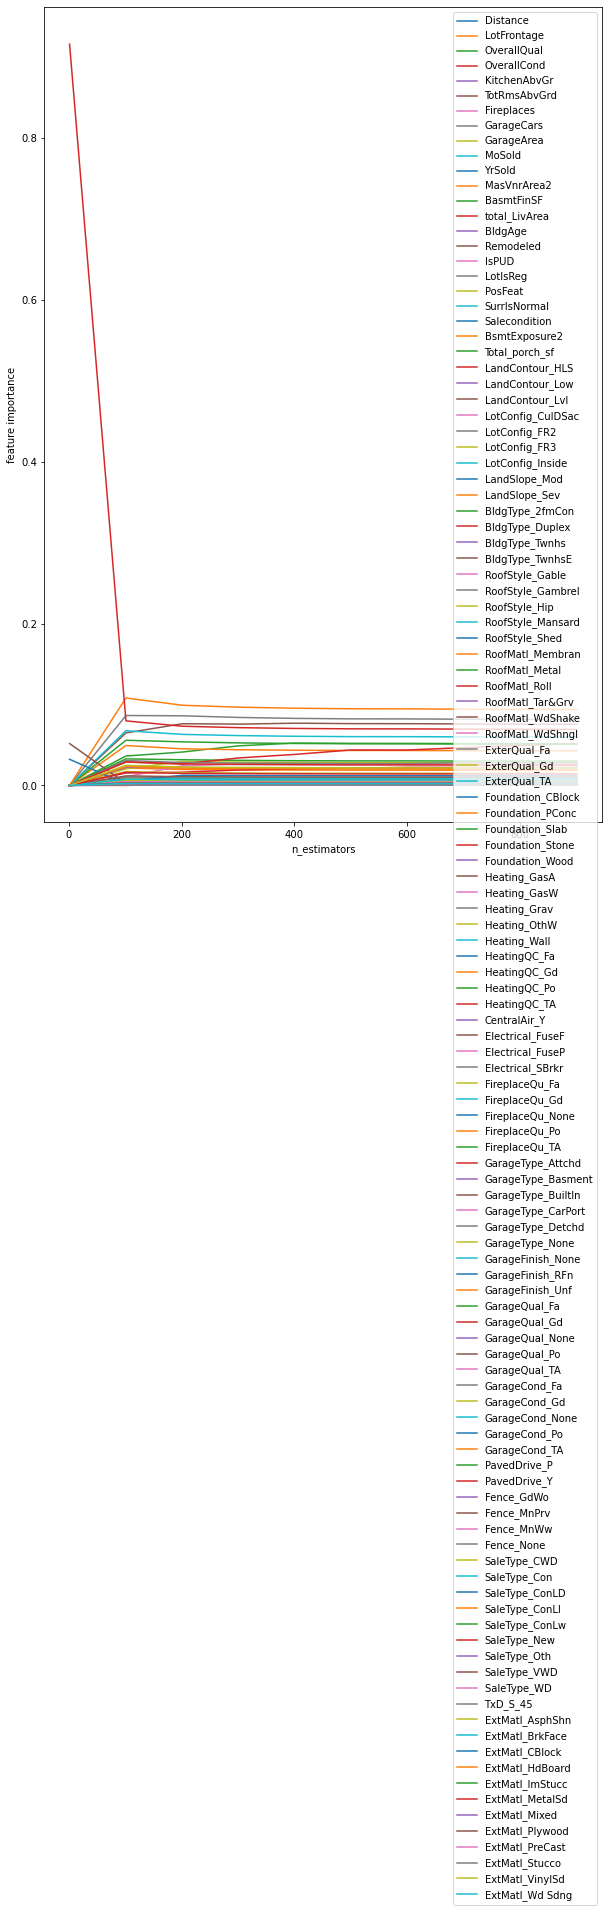

In [114]:
from copy import deepcopy
import plotly.express as px

gbm_models   = []
warm_start   = False
steps        = list(range(1,1001,100))

for n_estimators in steps:
                gbm.set_params(n_estimators=n_estimators, learning_rate=0.1, warm_start=warm_start)
                gbm_models.append(deepcopy(gbm.fit(X_train1, y_train1))) 
                warm_start = True
                
house_importance = pd.DataFrame([model.feature_importances_ for model in gbm_models], index=steps, columns=X_train1.columns)
house_importance
plt.rcParams['figure.figsize'] = (10,15)
for feature in house_importance.columns:
    plt.plot(house_importance.index, house_importance[feature], label=feature)
plt.legend(loc=1)    
plt.xlabel('n_estimators')
plt.ylabel('feature importance')

In [ ]:
# for feature in house_importance.columns:
#     px.line(house_importance.index, house_importance[feature], label=feature)

In [ ]:
import statsmodels.api as sm
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)


In [ ]:
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

In [ ]:
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

In [ ]:
# from sklearn.metrics import r2_score
# lin_reg_pred = lin_reg.predict(X_test)
# sum((y_test - lin_reg_pred)**2)/sum((y_test - np.mean(y_test))**2)
# mean_squared_error(X_test,y_test)
# lin_reg_pred
# len(y_test)
# r2_score(y_test,lin_reg_pred)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# housing_prediction = lin_reg.predict(X_test)
# mean_squared_error(y_train,y_test)
# lin_reg2 = LinearRegression().fit(X_train,y_train)
# lin_reg.r2_score